[Cython wrapper for Container Loading Problems](http://www.diku.dk/~pisinger/codes.html)

The paper "A tree-search heuristic for the Container Loading Problem" by D.Pisinger (1999), presents a code for knapsack loading a container. The code container.c is a callable C-procedure which can be used in several applications. The program testconc.c generates test instances. 

C source files are slightly modified to fix some build errors. Application is wrapped with Python using Cython.

We use the container function for pallet loading (same problem with different axis)

In [9]:
%%file container.pyx
import cython
import numpy as np
cimport numpy as np

cdef extern from "pisinger/container.c":
   void contload(int n, int W, int H, int D, 
                 int *w, int *h, int *d,
                 int *x, int *y, int *z, int *k,
                 int *vol)



@cython.boundscheck(False)
@cython.wraparound(False)
def cy_contload(int m, int W, int H, int D,
                np.ndarray[int, ndim=1, mode="c"] w not None,
                np.ndarray[int, ndim=1, mode="c"] h not None,
                np.ndarray[int, ndim=1, mode="c"] d not None,
                np.ndarray[int, ndim=1, mode="c"] x not None,
                np.ndarray[int, ndim=1, mode="c"] y not None,
                np.ndarray[int, ndim=1, mode="c"] z not None,
                np.ndarray[int, ndim=1, mode="c"] k not None):
    """
    python wrapper of contload c funtion
    """
    cdef int n
    cdef int vol

    n = m

    contload(n, W, H, D, &w[0], &h[0], &d[0], &x[0], &y[0], &z[0], &k[0], &vol)

    return vol


Overwriting container.pyx


In [10]:
%%file testcont.pyx
import cython
import numpy as np
cimport numpy as np


cdef extern from "pisinger/testcont.c":
    int random_load(int W, int H, int D,
                int *w, int *h, int *d,
                    int mindim, int maxdim, int fillpct, int maxtyp)


@cython.boundscheck(False)
@cython.wraparound(False)
def cy_randload(int W, int H, int D,
                np.ndarray[int, ndim=1, mode="c"] w not None,
                np.ndarray[int, ndim=1, mode="c"] h not None,
                np.ndarray[int, ndim=1, mode="c"] d not None,
                int mindim=25, int maxdim=115, int fillpct=90, int maxtyp=20):
    """
    python wrapper of testcont funtion random_load
    """
    cdef int n

    n = random_load( W, H, D, &w[0], &h[0], &d[0], mindim, maxdim, fillpct, maxtyp)

    return n


Overwriting testcont.pyx


In [11]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy

extensions = [Extension("contload",
                         ['container.pyx'],
                         include_dirs=[numpy.get_include()]
                         ),
              Extension("testcont",
                         ['testcont.pyx'],
                         include_dirs=[numpy.get_include()]
                         )]

setup(
    cmdclass={'build_ext': build_ext},
    ext_modules = extensions
)

Overwriting setup.py


In [12]:
%run setup.py build_ext --inplace

running build_ext
cythoning container.pyx to container.c
building 'contload' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/opt/miniconda3/include -arch x86_64 -I/opt/miniconda3/lib/python3.5/site-packages/numpy/core/include -I/opt/miniconda3/include/python3.5m -c container.c -o build/temp.macosx-10.9-x86_64-3.5/container.o
gcc -bundle -undefined dynamic_lookup -Wl,-rpath,/opt/miniconda3/lib -L/opt/miniconda3/lib -headerpad_max_install_names -arch x86_64 build/temp.macosx-10.9-x86_64-3.5/container.o -L/opt/miniconda3/lib -o /Users/navaro/notebooks-python/contload.cpython-35m-darwin.so
cythoning testcont.pyx to testcont.c
building 'testcont' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/opt/miniconda3/include -arch x86_64 -I/opt/miniconda3/lib/python3.5/site-packages/numpy/core/include -I/opt/miniconda3/include/python3.5m -c testcont.c -o bui

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


class Pallet(object):
    def __init__(self, length, width, height):

        self._l = length
        self._w = width
        self._h = height

    @property
    def volume(self):
        return self._l * self._w * self._h

    def plot(self):
        self.fig = plt.figure()
        self.ax = Axes3D(self.fig)
        self.ax.set_xlim([0, self._l])
        self.ax.set_ylim([0, self._w])
        self.ax.set_zlim([0, self._h])
        self.ax.grid(True)
        corners = np.array([[0, 0, 0],
                            [self._l, 0, 0],
                            [self._l, self._w, 0],
                            [0, self._w, 0],
                            [0, 0, self._h],
                            [self._l, 0, self._h],
                            [self._l, self._w, self._h],
                            [0, self._w, self._h]])

        self.ax.scatter3D(corners[:, 0], corners[:, 1], corners[:, 2])

In [22]:
from contload import cy_contload as cont_load
from testcont import cy_randload as random_load

class BoxList(object):
    """ Class used to make loop over boxes """

    def __init__(self, maxitems=1000):
        self.boxdata = BoxData(maxitems)
        self.numberof = self.boxdata.numberof

    def __getitem__(self, index):
        self.boxdata.index = index
        return self.boxdata

    def __len__(self):
        return self.numberof

    def __iter__(self):
        for i in range(self.numberof):
            self.boxdata.index = i
            yield self.boxdata

    @property
    def volume(self):
        """ :returns the total volume of all packed boxes"""
        return np.sum(self.boxdata._l[np.where(self.boxdata._k > 0)] 
                      * self.boxdata._w[np.where(self.boxdata._k > 0)] * self.boxdata._h[
            np.where(self.boxdata._k > 0)])

    def load(self, p):
        """ 
            Run the function written by David Pisinger to fill a container of size W, H, D
            :return: the total volume of boxes packed in the container

        """
        assert (isinstance(p, Pallet))
        return self.boxdata.contload(p)

    def sample(self, p, mindim=25, maxdim=115, fillpct=90, maxtyp=1):
        """
                Create a box distribution.
                :param p: the pallet
                :param mindim: Minimum dimension of boxes
                :param maxdim: Maximum dimension of boxes
                :param fillpct: Boxes are generated until "fillpct" percent of the container volume
                :param maxtyp: Number of different box types
                :return: Number of  box
                """

        return self.boxdata.random_load(p, mindim, maxdim, fillpct, maxtyp)


n = 112
28394660
 Volume =  28394660


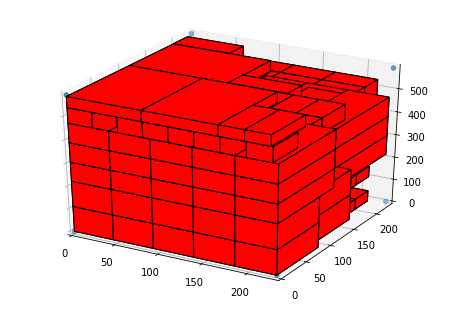

In [24]:
%matplotlib inline
import numpy as np
from testcont import cy_randload as random_load
from contload import cy_contload as cont_load
from box import BoxList
from pallet import Pallet

# Test for a container

W, H, D = 230, 230, 590 # Set the container dimensions
p = Pallet(W, H, D) # We replace the pallet height by the container depth
blist = BoxList() # Create the box list from box data (maximum number of box is 1000)
n = blist.sample(p, mindim=25, maxdim=115, fillpct=90, maxtyp=2) # Create a random load of box
print("n = " + str(n))
vol = blist.load(p) # Load the container and set box positions.

print(blist.volume) # Print the total volume
print(" Volume = ", vol)

p.plot()
for box in blist: # Loop over boxes
    box.add_to_pallet(p) # Add each box to the pallet plot


## Voxel

Try to replace scatter3d by [new feature voxels](https://matplotlib.org/devdocs/users/whats_new.html#voxels-function-for-mplot3d) in matplotlib 2.1

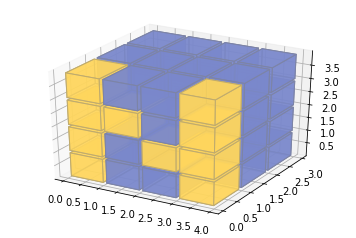

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# build up the numpy logo
n_voxels = np.zeros((4, 3, 4), dtype=bool)
n_voxels[0, 0, :] = True
n_voxels[-1, 0, :] = True
n_voxels[1, 0, 2] = True
n_voxels[2, 0, 1] = True
facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
filled = np.ones(n_voxels.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2);

